In [195]:
# Import libaries
import re
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [196]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [197]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp
import reload_lib as rl


# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'
# Specifying the LCIA method
lcia_method = 'recipe'
lib = [s, MC, lc, lp, bp]

In [198]:
def break_even_initialization(path, lcia_method, lib):
    
    rl.reload_lib(lib)
    flow_legend, database_name, file_name, sheet_name, save_dir, initialization, file_name_unique, db_type = lc.initilization(path, lcia_method)
    df, plot_x_axis_all, impact_categories = lc.quick_LCIA(initialization, file_name, file_name_unique, sheet_name)
    df_rearranged = lc.rearrange_dataframe_index(df)
    if 'recipe' in lcia_method:
        df_res, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
        plot_x_axis_end = plot_x_axis_all[-3:]
        ic_mid = plot_x_axis_all[:-3] 
        plot_x_axis = []
        for ic in ic_mid:
            # print(ic)
            string = re.findall(r'\((.*?)\)', ic)
            if 'ODPinfinite' in  string[0]:
                string[0] = 'ODP'
            elif '1000' in string[0]:
                string[0] = 'GWP'
            plot_x_axis.append(string[0])

    else:
        df_res = df_rearranged
        plot_x_axis = plot_x_axis_all
    
    
    df_col = [df_res.columns[1]]
    df_GWP = df_res[df_col]

    return database_name, df_GWP, db_type, database_name, flow_legend

In [199]:
database_name, df_GWP, db_type, database_name, flow_legend = break_even_initialization(path, lcia_method, lib)

The chosen project is SU_vs_MU and the chosen database is sterilization
Folder name Results created
Chosen flows:
H200 REC - CONSQ
H200 SU - CONSQ
H400 REC- CONSQ
H400 SU - CONSQ
alubox large + washer - CONSQ
alubox large + wipe - CONSQ
alubox small + washer - CONSQ
alubox small + wipe - CONSQ
Recipe is selected
Initialization is completed
DataFrame with nested lists written to Excel successfully.


In [200]:
rl.reload_lib(lib)
columns = lc.unique_elements_list(database_name)
df_stack_updated, totals_df = lp.process_categorizing(df_GWP, db_type, database_name, 'break even', flow_legend, columns)
df_be = lp.break_even_orginization(df_stack_updated, database_name)

In [246]:
df_err = pd.DataFrame(0, index=df_be.index, columns=df_be.columns, dtype=object)

lst_std = [199, 827]

lst_rec = [0.25, 0.8]

use_dct = {}
sheet_dct  = {}
for idx in df_err.index:
    if '2' in idx:
        use_dct[idx] = [12,18]
        sheet_dct[idx] = [190, 202]
    elif '4' in idx:
        use_dct[idx] = [8,9]
        sheet_dct[idx] = [63, 71]
    elif 'S' in idx:
        use_dct[idx] = [9,12]
    else:
        use_dct[idx] = [6,9]



for col in df_err.columns:
    for idx, row in df_err.iterrows():
        if 'H' not in idx and 'Disinfection' not in col and 'Autoclave' not in col:
            temp = 0
            for std in lst_std:
                row[col] = abs(df_be.at[idx, col] * std / 513 - temp)/2
                temp = df_be.at[idx, col] * std / 513
        elif 'Autoclave' in col:
            temp = 0
            for ac in use_dct[idx]:
                row[col] = abs(df_be.at[idx, col] * ac / use_dct[idx][0] - temp)/2
                temp = df_be.at[idx, col] * ac / use_dct[idx][0]
        elif 'R' in idx and ('Incineration' in col or 'Avoided energy prod.' in col or	'Avoided mat. prod.' in col):
            temp = 0
            for rec in lst_rec:
                row[col] = abs(df_be.at[idx, col] * rec / 0.54 - temp)/2
                temp = df_be.at[idx, col] * rec / 0.54
        elif 'H' in idx and ('Disinfection' not in col  and 'Autoclave' not in col and 'Recycling' not in col):
            temp = 0
            for prot in sheet_dct[idx]:
                row[col] = abs((df_be.at[idx, col] * prot / sheet_dct[idx][1] - temp/1000))/2
                temp = df_be.at[idx, col] * prot / sheet_dct[idx][1]
        else:
            row[col] = 0

df_err

,Raw mat. + prod.,Disinfection,Autoclave,Recycling,Incineration,Avoided energy prod.,Avoided mat. prod.
H2S,0.115439,0,0.078405,0,0.089501,0.111956,0.003443
H2R,0.115439,0,0.078405,0,0.041972,0.052503,0.050358
ASC,0.067691,0,0.069693,0.001848,0.000232,0.000385,0.055174
ASW,0.067691,0,0.069693,0.001848,0.000232,0.000385,0.055174
H4S,0.330987,0,0.029402,0,0.254389,0.318541,0.009797
H4R,0.330987,0,0.029402,0,0.118916,0.149375,0.144029
ALC,0.113499,0,0.15681,0.003093,0.000464,0.000769,0.092336
ALW,0.113499,0,0.15681,0.003093,0.000464,0.000769,0.092336


In [247]:
tot_err_dict = {}

for idx, row in df_err.iterrows():
    tot_err = 0
    for col in df_err.columns:
        tot_err += row[col]
    tot_err_dict[idx] = tot_err



In [248]:
df_tot_err = df = pd.DataFrame(list(tot_err_dict.values()), index=tot_err_dict.keys(), columns=['Value'])
totals_df.index = df_err.index

totals_df = totals_df['Value'].to_frame()


In [249]:
df_tot_err

,Value
H2S,0.398744
H2R,0.338677
ASC,0.195023
ASW,0.195023
H4S,0.943115
H4R,0.772710
ALC,0.366971
ALW,0.366971


In [250]:
plt_index = [i for i in totals_df.index]

In [251]:
colors = s.plot_colors(plt_index,'turbo')


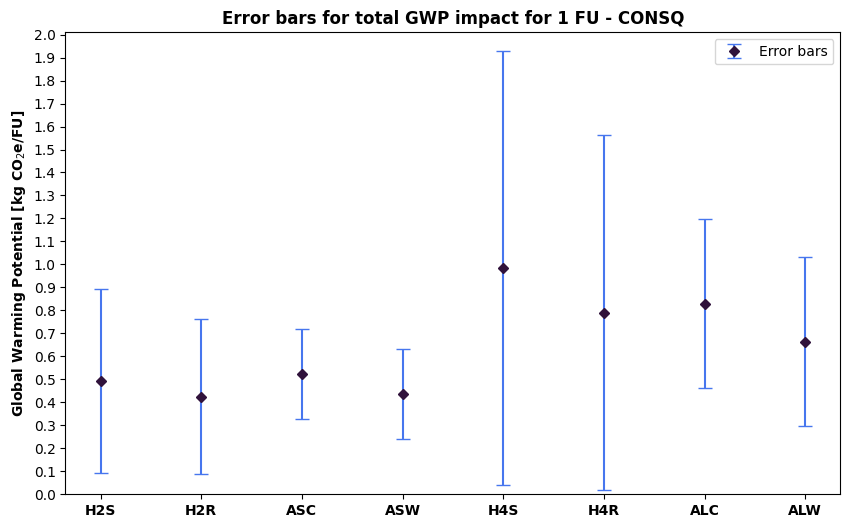

In [266]:
x = []
y = []
y_err = []
for col in totals_df.columns:
    for x_val, (idx, row) in enumerate(totals_df.iterrows()):
        x.append(float(x_val + 1))
        y.append(row[col])
        y_err.append(df_tot_err.at[idx, col])

fig, ax = plt.subplots(figsize=(10, 6))

# Plot with customized marker colors
plt.errorbar(x, y,
             yerr=y_err,
             fmt='D',                     # Marker style
             capsize=5,                   # Add caps
             ecolor=colors[1],                # Color of error bars
             markerfacecolor=colors[0],      # Fill color of the marker
             markeredgecolor=colors[0],     # Outline color of the marker
             markersize=5,
             label="Error bars")                # Size of the marker

plt.legend()  # Add legend to differentiate columns
ax.set_xticks(x)
ax.set_xticklabels(plt_index, fontsize=10, weight='bold')
# ax.axhline(y = -0.004, color = 'k', linestyle = '-', zorder=0, linewidth=0.5) # https://matplotlib.org/stable/gallery/misc/zorder_demo.html
plt.yticks(np.arange(0, 2.01, step=0.1))
plt.ylim(0, 2.01)
plt.ylabel("Global Warming Potential [kg CO$_2$e/FU]", fontsize=10, weight='bold')  # Label for y-axis
plt.title(f"Error bars for total GWP impact for 1 FU - {db_type}", weight='bold')  # Add title
plt.show()  